## Try to maximize the likelihood using iminuit (CMB parameterization)

See tutorials here: https://nbviewer.jupyter.org/github/scikit-hep/iminuit/tree/master/tutorial/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our modules
import camb_cosmo
import CAMB_model
import full_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data
test_sim_num=15
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,
                                basedir=basedir,
                                skewers_label=skewers_label,
                                data_cov_factor=1)

Setup archive of P1D measurements from simulations to train the emulator

In [3]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [4]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Library/Python/3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Setup FullTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [5]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    sim_cosmo=emu.arxiv.get_simulation_cosmology(test_sim_num)
    print('use true cosmo as fiducial')
    camb_cosmo.print_info(sim_cosmo)
    camb_model_sim=CAMB_model.CAMBModel(zs=data.z,cosmo=sim_cosmo)
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_sim)
else:
    theory=full_theory.FullTheory(zs=data.z,emulator=emu)
    print('use default cosmo as fiducial')
    camb_cosmo.print_info(theory.camb_model_fid.cosmo)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


Setup likelihood and free parameters

In [6]:
# Likelihood parameters (option to fix cosmology)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0","ln_kF_0"]
    like_param_limits=[[-0.2, 0.2],[-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]
else:
    like_params=["As","ns","ln_tau_0","ln_sigT_kms_0",
            "ln_gamma_0","ln_kF_0"]
    like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.05], [-0.2, 0.2],
            [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]

In [7]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=0.5,
                            emu_cov_factor=1)

In [8]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
As = 1.9999999999999997e-09
ns = 0.9750000000000001
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
ln_kF_0 = 0.0
starting chi2 867.1294844094404


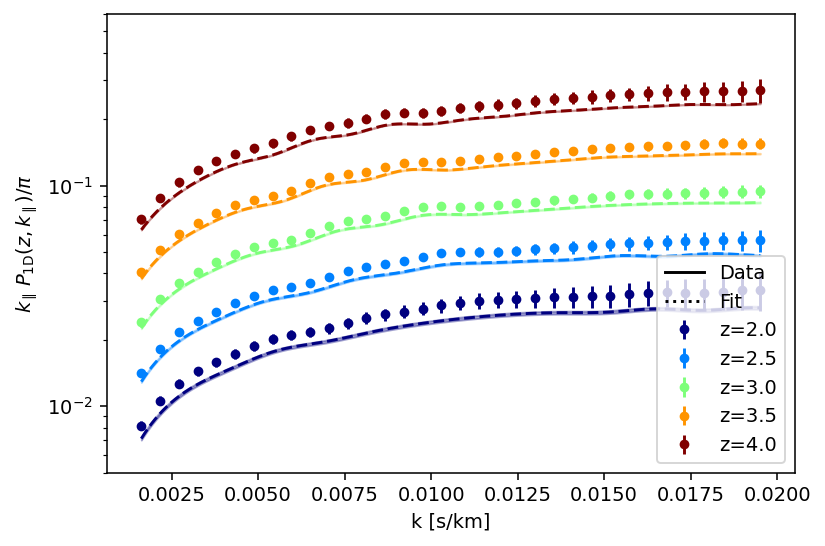

In [9]:
like.plot_p1d(plot_every_iz=2)

### Setup our own minimizer

In [10]:
import iminuit_minimizer

In [11]:
minimizer = iminuit_minimizer.IminuitMinimizer(like,verbose=True)

best-fit values = [0.5 0.5 0.5 0.5 0.5 0.5]


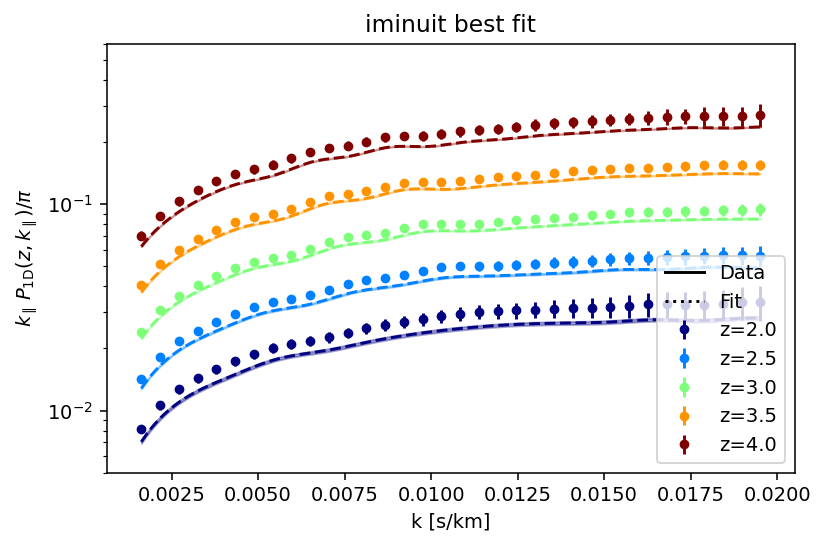

In [12]:
minimizer.plot_best_fit()

In [13]:
minimizer.minimize()

will run migrad


 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


will compute Hessian matrix


best-fit values = [0.33915327 0.44343082 0.75611616 0.27725625 0.23412165 0.4723255 ]


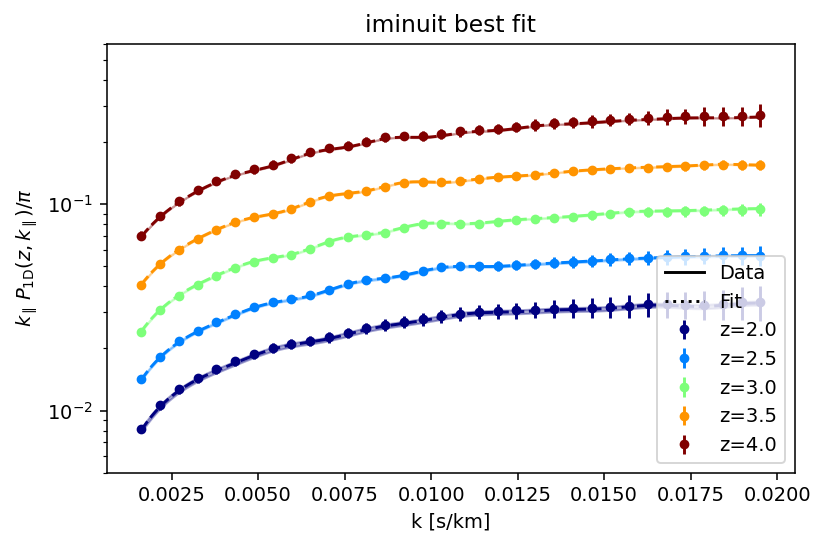

In [14]:
minimizer.plot_best_fit()

In [15]:
best_fit_values=minimizer.minimizer.np_values()
print('best fit values',best_fit_values)

best fit values [0.33915327 0.44343082 0.75611616 0.27725625 0.23412165 0.4723255 ]


# Run iminuit minimiser

In [16]:
from iminuit import Minuit

In [17]:
# setup iminuit
m = Minuit.from_array_func(like.minus_log_prob,theta,error=0.02,errordef=0.5)

In [18]:
# run optimiser
m.migrad()

 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


------------------------------------------------------------------
| FCN = 35.8                    |     Ncalls=397 (397 total)     |
| EDM = 2.78e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.339   |   0.035   |            |            |         |         |       |
| 1 | x1   |   0.44    |   0.05    |            |            |         |         |       |
| 2 | x2   |   0.756   |   0.023   |            |            |         |         |       |
| 3 | x3   |   0.28    |   0.33    |            |            |         |         |       |
| 4 | x4   |   0.23    |   0.09    |            |            |         |         |       |
| 5 | x5   |   0.47    |   0.05    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [19]:
# access results again
print('best fit values =',m.values)
m.get_fmin()

best fit values = <ValueView of Minuit at 7fa807caa738>
  x0: 0.3391532735385277
  x1: 0.4434308175209622
  x2: 0.7561161644686638
  x3: 0.27725625352059635
  x4: 0.2341216523976052
  x5: 0.4723255045600501


------------------------------------------------------------------
| FCN = 35.8                    |     Ncalls=397 (397 total)     |
| EDM = 2.78e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------

In [20]:
min_chi2=like.get_chi2(m.values)
print('minimum chi2',min_chi2)
for par in like.parameters_from_sampling_point(m.values):
    print(par.info_str())

minimum chi2 4.561344750753912
As = 1.6783065470770555e-09
ns = 0.9665146226281444
ln_tau_0 = 0.10244646578746552
ln_sigT_kms_0 = -0.08909749859176147
ln_gamma_0 = -0.10635133904095792
ln_kF_0 = -0.011069798175979945


In [21]:
# compare to truth
sim_cosmo=emu.arxiv.get_simulation_cosmology(test_sim_num)
print('true As =',sim_cosmo.InitPower.As)
print('true ns =',sim_cosmo.InitPower.ns)

true As = 1.765434e-09
true ns = 0.965899


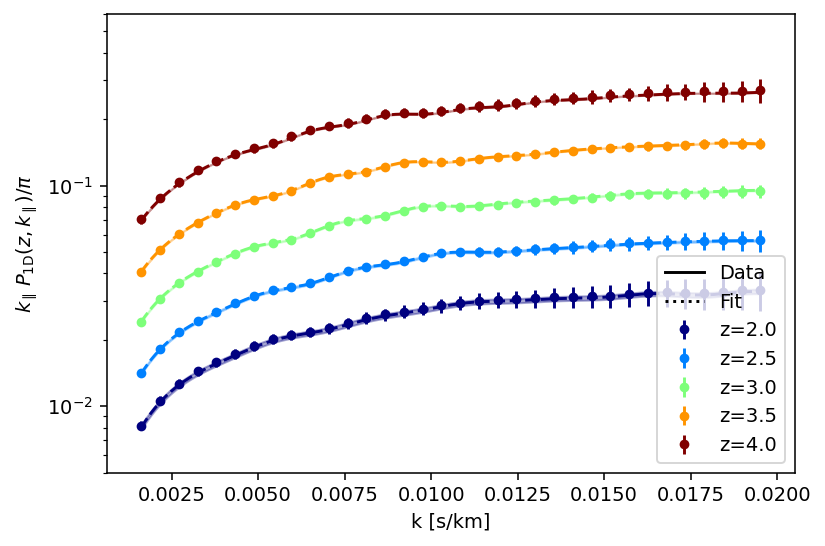

In [22]:
like.plot_p1d(plot_every_iz=2,values=m.values)

# Other cool things we can do with iminuit

In [23]:
# get Gaussian approximated errors
m.hesse()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.34    |   0.04    |            |            |         |         |       |
| 1 | x1   |   0.44    |   0.05    |            |            |         |         |       |
| 2 | x2   |   0.756   |   0.024   |            |            |         |         |       |
| 3 | x3   |   0.28    |   0.33    |            |            |         |         |       |
| 4 | x4   |   0.23    |   0.09    |            |            |         |         |       |
| 5 | x5   |   0.47    |   0.05    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [24]:
# get proper errors from likelihood scans
m.minos()

 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


------------------------------------------------------------------------------------------------------------------------------------------------------------
|          |          x0           |          x1           |          x2           |          x3           |          x4           |          x5           |
------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Error   |  -0.036   |   0.033   |   -0.05   |   0.05    |  -0.024   |   0.023   |   -0.33   |   0.36    |   -0.07   |   0.11    |   -0.05   |   0.05    |
|  Valid   |   True    |   True    |   True    |   True    |   True    |   True    |   False   |   True    |   True    |   True    |   True    |   True    |
| At Limit |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |
| Max FCN  |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |
| New Min  |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |
------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
# get best-fit values
m.np_values()

array([0.33915327, 0.44343082, 0.75611616, 0.27725625, 0.23412165,
       0.4723255 ])

In [26]:
like.get_free_parameter_list()

['As', 'ns', 'ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0']

In [27]:
# get parameters covariance
m.np_covariance()

array([[ 1.27215357e-03, -2.51793590e-04, -7.26689192e-04,
         5.24188072e-03,  1.39874021e-03,  1.11422080e-03],
       [-2.51793590e-04,  2.50096926e-03, -2.08258453e-04,
        -2.81917678e-03, -7.65243875e-05, -1.31220996e-03],
       [-7.26689192e-04, -2.08258453e-04,  5.66807432e-04,
        -3.74238436e-03, -4.31855636e-04, -5.37193729e-04],
       [ 5.24188072e-03, -2.81917678e-03, -3.74238436e-03,
         1.11111358e-01,  1.27428143e-02,  7.33696797e-03],
       [ 1.39874021e-03, -7.65243875e-05, -4.31855636e-04,
         1.27428143e-02,  7.67000066e-03,  1.66784698e-03],
       [ 1.11422080e-03, -1.31220996e-03, -5.37193729e-04,
         7.33696797e-03,  1.66784698e-03,  2.40300419e-03]])

(array([0.34341143, 0.36563796, 0.38786449, 0.41009102, 0.43231755,
        0.45454408, 0.47677061, 0.49899714, 0.52122367, 0.5434502 ]),
 array([37.75513258, 37.00071253, 36.42129478, 36.02660854, 35.82606066,
        35.8240862 , 36.01391677, 36.37420704, 36.86842905, 37.44663071]))

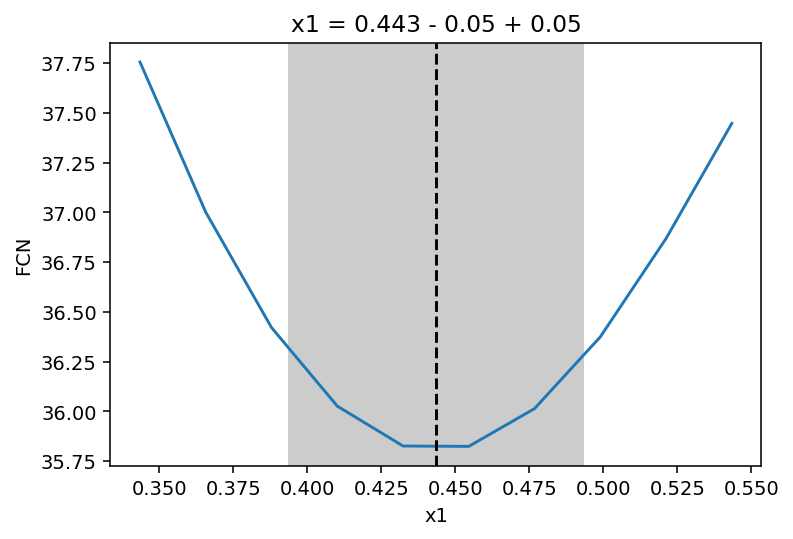

In [28]:
# scan one parameter and plot minus log posterior
m.draw_mnprofile(vname='x1',bins=10)

 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


(array([-0.38941115, -0.24126284, -0.09311453,  0.05503378,  0.2031821 ,
         0.35133041,  0.49947872,  0.64762704,  0.79577535,  0.94392366]),
 array([        inf,         inf,         inf, 36.08416706, 35.8272668 ,
        35.8245431 , 36.00154317, 36.33780091, 36.84049332, 37.51891299]))

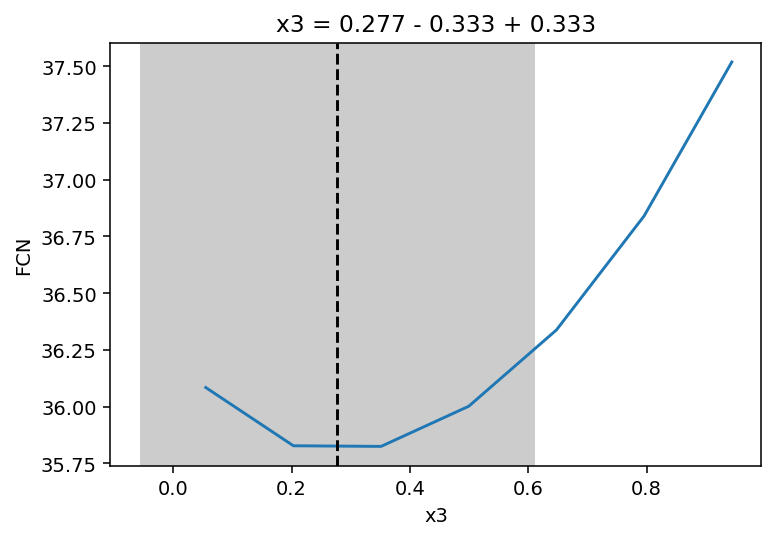

In [29]:
# for another parameter
m.draw_mnprofile(vname='x3',bins=10)

(array([0.26781875, 0.27532765, 0.28283654, 0.29034544, 0.29785434,
        0.30536324, 0.31287213, 0.32038103, 0.32788993, 0.33539882,
        0.34290772, 0.35041662, 0.35792552, 0.36543441, 0.37294331,
        0.38045221, 0.38796111, 0.39547   , 0.4029789 , 0.4104878 ]),
 array([0.34341143, 0.35393979, 0.36446815, 0.3749965 , 0.38552486,
        0.39605321, 0.40658157, 0.41710993, 0.42763828, 0.43816664,
        0.448695  , 0.45922335, 0.46975171, 0.48028006, 0.49080842,
        0.50133678, 0.51186513, 0.52239349, 0.53292184, 0.5434502 ]),
 array([[20.51584537, 20.22390679, 19.90213273, 19.55586061, 19.19156577,
         18.81679519, 18.43999502, 18.0700142 , 17.71504359, 17.38082147,
         17.06820835, 16.77081795, 16.47422031, 16.15873364, 15.80683913,
         15.41312971, 14.99133813, 14.57339128, 14.2006503 , 13.91270203],
        [18.5454409 , 18.18099942, 17.78688367, 17.36832313, 16.93172352,
         16.48459826, 16.03537839, 15.59288823, 15.16527441, 14.75829036,
       

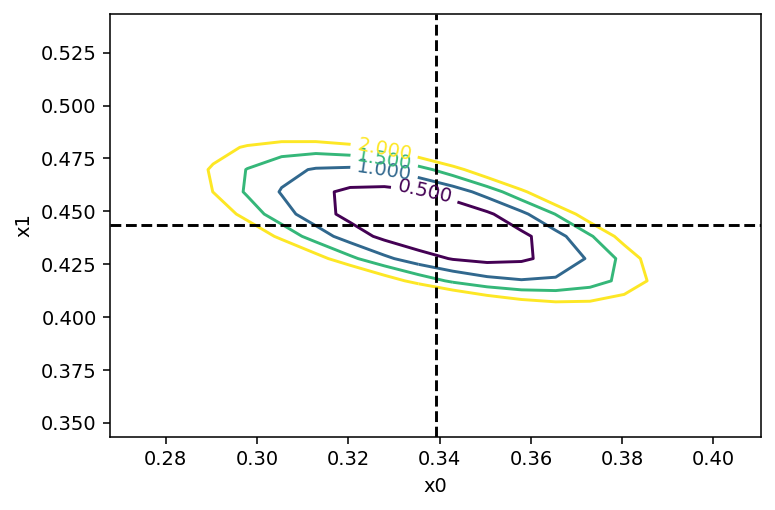

In [30]:
# 2D contours
m.draw_contour('x0','x1',bins=20)

In [31]:
# matrix correlations
m.matrix(correlation=True)

--------------------------------------------------
|    |     x0     x1     x2     x3     x4     x5 |
--------------------------------------------------
| x0 |  1.000 -0.141 -0.856  0.441  0.448  0.637 |
| x1 | -0.141  1.000 -0.175 -0.169 -0.017 -0.535 |
| x2 | -0.856 -0.175  1.000 -0.472 -0.207 -0.460 |
| x3 |  0.441 -0.169 -0.472  1.000  0.437  0.449 |
| x4 |  0.448 -0.017 -0.207  0.437  1.000  0.388 |
| x5 |  0.637 -0.535 -0.460  0.449  0.388  1.000 |
--------------------------------------------------